범죄 카테고리 맞추기
https://www.kaggle.com/c/sf-crime

In [1]:
import xgboost as xgb
import pandas as pd

In [2]:
train= pd.read_csv("data/train.csv", parse_dates=['Dates'])

print(train.shape)
train.head()
# Category, Descript, Resolution 은 train에만 있음
#pdDistrict, Address, X, Y

(878049, 9)


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [3]:
test= pd.read_csv("data/test.csv", parse_dates=['Dates'])

print(test.shape)
test.head()


(884262, 7)


,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [4]:
# train["Category"].unique()
# 'WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT',
#        'VANDALISM', 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS',
#        'BURGLARY', 'SUSPICIOUS OCC', 'DRUNKENNESS',
#        'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC', 'STOLEN PROPERTY',
#        'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
#        'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
#        'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT',
#        'ARSON', 'FAMILY OFFENSES', 'LIQUOR LAWS', 'BRIBERY',
#        'EMBEZZLEMENT', 'SUICIDE', 'LOITERING', 'SEX OFFENSES NON FORCIBLE',
#        'EXTORTION', 'GAMBLING', 'BAD CHECKS', 'TREA', 'RECOVERED VEHICLE',
#        'PORNOGRAPHY/OBSCENE MAT
# train["DayOfWeek"].unique()
# 'Wednesday', 'Tuesday', 'Monday', 'Sunday', 'Saturday', 'Friday','Thursday
# train["PdDistrict"].unique() 
#'NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL','TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN'
# train["Address"].unique()
# split 필요. 많음

## preprocessing

### one-hot encoding

DayOfWeek

In [5]:
cols=['Wednesday', 'Tuesday', 'Monday', 'Sunday', 'Saturday', 'Friday','Thursday']
# cols= train["DayOfWeek"].unique()
for col in cols:
    train["Days_"+col]= (train["DayOfWeek"]== col)

Category

In [6]:
cols= train["Category"].unique(); cols
for col in cols:
    train["Cate"+col]= (train["Category"]== col)

PdDistrict

In [7]:
cols= train["PdDistrict"].unique(); cols
for col in cols:
    train["PdD_"+col]= (train["PdDistrict"]== col)

Resolution

In [8]:
cols= train["Resolution"].unique(); cols
for col in cols:
    train["Res_"+col]= (train["Resolution"]== col)

### tokenize- stemma

In [9]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.stem.snowball import SnowballStemmer
stemmer= SnowballStemmer('english')
stemmer

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\optim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\optim\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
from tqdm import tqdm
def stem_phrase(phrase):
    words = phrase.split(" ")

    stemmed_words = [stemmer.stem(w) for w in words]
    stemmed_phrase = " ".join(stemmed_words)

    return stemmed_phrase

tqdm.pandas(desc="stemming...")

Descript

In [11]:
train["Descript(Stemmed)"] = train["Descript"].progress_apply(stem_phrase)

stemming...: 100%|██████████████████████████████████████████████████████████| 878049/878049 [01:08<00:00, 12885.90it/s]


Address

In [12]:
train["Address(Stemmed)"] = train["Address"].progress_apply(stem_phrase)

stemming...: 100%|██████████████████████████████████████████████████████████| 878049/878049 [00:55<00:00, 15836.54it/s]


In [13]:
newTrain= train.drop(columns=['Descript', 'DayOfWeek', 'PdDistrict', 'Resolution', 'Address'])

In [14]:
newTrain.tail()

,Dates,Category,X,Y,Days_Wednesday,Days_Tuesday,Days_Monday,Days_Sunday,Days_Saturday,Days_Friday,...,Res_NOT PROSECUTED,Res_JUVENILE DIVERTED,Res_COMPLAINANT REFUSES TO PROSECUTE,Res_JUVENILE ADMONISHED,Res_JUVENILE CITED,Res_DISTRICT ATTORNEY REFUSES TO PROSECUTE,Res_PROSECUTED BY OUTSIDE AGENCY,Res_PROSECUTED FOR LESSER OFFENSE,Descript(Stemmed),Address(Stemmed)
878044,2003-01-06 00:15:00,ROBBERY,-122.459033,37.714056,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,robberi on the street with a gun,farallon st / capitol av
878045,2003-01-06 00:01:00,LARCENY/THEFT,-122.447364,37.731948,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,grand theft from lock auto,600 block of edna st
878046,2003-01-06 00:01:00,LARCENY/THEFT,-122.403390,37.780266,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,grand theft from lock auto,5th st / folsom st
878047,2003-01-06 00:01:00,VANDALISM,-122.390531,37.780607,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,"malici mischief, vandal of vehicl",townsend st / 2nd st
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,-122.394926,37.738212,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,"checks, forgeri (felony)",1800 block of newcomb av


In [15]:
# Address(Stemmed) 를 / 혹은 of 기준으로 쪼개서 새로운 두 칼럼으로 뽑고 싶다
#시도1
# newTrain = pd.DataFrame["Address(Stemmed)"](newTrain.row.str.split('of',1).tolist()
#                                             , columns = ['Address(Stemmed)Big','Address(Stemmed)smal'])
#시도2
# import re
# DATA = "Hey, you - what are you doing here!?"
# print re.split('\W+', DATA) # ['Hey', 'you', 'what', 'are', 'you', 'doing', 'here', '']
def split_address(address):
    if "/" in address:
        return address.split("/")
    else:
        return address.split("of")

In [16]:
# trim?? strip ???

# 칼럼 2개로 나눠받기??
train["Address(Stemmed)"].apply(split_address)
# train["Address(Stemmed)Aft"],train["Address(Stemmed)Bef"]= map(unlist(train["Address(Stemmed)"].apply(split_address)))


0                    [oak st ,  laguna st]
1                    [oak st ,  laguna st]
2                 [van av ,  greenwich st]
3               [1500 block ,  lombard st]
4              [100 block ,  broderick st]
5                    [0 block ,  teddi av]
6                   [avalon av ,  peru av]
7               [kirkwood av ,  donahu st]
8                   [600 block ,  47th av]
9         [jefferson st ,  leavenworth st]
10        [jefferson st ,  leavenworth st]
11                 [0 block ,  escolta wy]
12                    [turk st ,  jone st]
13                [fillmor st ,  geari bl]
14               [200 block ,  william av]
15                  [0 block ,  mendel st]
16                    [eddi st ,  jone st]
17               [godeus st ,  mission st]
18                [mendel st ,  hudson av]
19                  [100 block ,  jone st]
20                [200 block ,  evelyn wy]
21             [1600 block ,  valencia st]
22                  [100 block ,  jone st]
23         

In [17]:
#남은 일: 새 두 칼럼으로 뽑기

In [18]:
# train.head()
list(train)

['Dates',
 'Category',
 'Descript',
 'DayOfWeek',
 'PdDistrict',
 'Resolution',
 'Address',
 'X',
 'Y',
 'Days_Wednesday',
 'Days_Tuesday',
 'Days_Monday',
 'Days_Sunday',
 'Days_Saturday',
 'Days_Friday',
 'Days_Thursday',
 'CateWARRANTS',
 'CateOTHER OFFENSES',
 'CateLARCENY/THEFT',
 'CateVEHICLE THEFT',
 'CateVANDALISM',
 'CateNON-CRIMINAL',
 'CateROBBERY',
 'CateASSAULT',
 'CateWEAPON LAWS',
 'CateBURGLARY',
 'CateSUSPICIOUS OCC',
 'CateDRUNKENNESS',
 'CateFORGERY/COUNTERFEITING',
 'CateDRUG/NARCOTIC',
 'CateSTOLEN PROPERTY',
 'CateSECONDARY CODES',
 'CateTRESPASS',
 'CateMISSING PERSON',
 'CateFRAUD',
 'CateKIDNAPPING',
 'CateRUNAWAY',
 'CateDRIVING UNDER THE INFLUENCE',
 'CateSEX OFFENSES FORCIBLE',
 'CatePROSTITUTION',
 'CateDISORDERLY CONDUCT',
 'CateARSON',
 'CateFAMILY OFFENSES',
 'CateLIQUOR LAWS',
 'CateBRIBERY',
 'CateEMBEZZLEMENT',
 'CateSUICIDE',
 'CateLOITERING',
 'CateSEX OFFENSES NON FORCIBLE',
 'CateEXTORTION',
 'CateGAMBLING',
 'CateBAD CHECKS',
 'CateTREA',
 'CateR

### data뭔건지좀 보자

In [19]:
train["Category"].value_counts()
#많이? 적게? 뭘 맞추는게 좋을까 -> 측정공식을 보고 알 수 있음
#logloss: sum

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

In [20]:
# # 에러터짐;; 
# import matplotlib.pyplot as plt
# import seaborn as sns

# Xs= list(train)

# fig, axs= plt,subplots(nrows= 9)
# # fig.set_size_inches(20,10)

# pl_sz= range(0,9)
# for Xn,i in zip(Xs, pl_sz):
#     sns.countplot(data= train, x=Xn, y="X", ax=axs[i])

In [21]:
# non numeric visualization ???????????????????????????????????????????????????????????????????????????
# barplot ㄴㄴ countplot ㅇㅇ
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

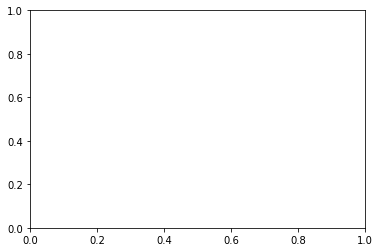

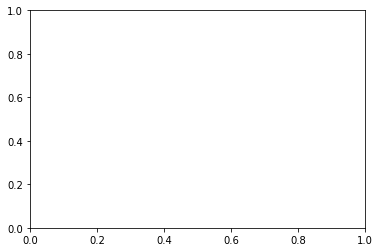

In [22]:
figure, ((ax2)) = plt.subplots(nrows=1)
fig, axs= plt,subplots(nrows= 1)
# figure.set_size_inches(20, 50)

# sns.countplot(data=train, x="Dates", ax=ax1)
# sns.countplot(data=train, x="Category", ax=ax2)
# sns.barplot(data=train, x="Descript", ax=ax3)

# sns.barplot(data=train, x="DayOfWeek", ax=ax4)
# sns.barplot(data=train, x="PdDistrict", ax=ax5)
# sns.barplot(data=train, x="Resolution", ax=ax6)

# sns.barplot(data=train, x="Address", ax=ax7)
# sns.barplot(data=train, x="X", ax=ax8)
# sns.barplot(data=train, x="Y",  ax=ax9)

### Train

In [23]:
feature_name= ["X","Y"]; feature_name

['X', 'Y']

In [24]:
X_train= train[feature_name]
print(X_train.shape)
X_train.head()

(878049, 2)


,X,Y
0,-122.425892,37.774599
1,-122.425892,37.774599
2,-122.424363,37.800414
3,-122.426995,37.800873
4,-122.438738,37.771541


In [25]:
X_test= test[feature_name]
print(X_test.shape)
X_test.head()

(884262, 2)


,X,Y
0,-122.399588,37.735051
1,-122.391523,37.732432
2,-122.426002,37.792212
3,-122.437394,37.721412
4,-122.437394,37.721412


In [26]:
label_name= "Category"
y_train= train[label_name]

print(y_train.shape)
y_train.head()

(878049,)


0          WARRANTS
1    OTHER OFFENSES
2    OTHER OFFENSES
3     LARCENY/THEFT
4     LARCENY/THEFT
Name: Category, dtype: object

### xgboost

In [27]:
import xgboost as xgb

In [28]:
model= xgb.XGBClassifier(n_estimators= 15,
                        nthread=4)
# nthread=4: tree 개수
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=15,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### score

In [29]:
from sklearn.model_selection import cross_val_score

# %time score= cross_val_score(model, X_train, y_train, cv=5).mean()
%time score= cross_val_score(model, X_train, y_train,\
                             cv=5, scoring="neg_log_loss").mean()
score= -1.0* score
print("Score= {0:.5f}".format(score))


Wall time: 22min 4s
Score= 2.81218


요 코드만 15분 정도 걸릴것
##  
초기:
Wall time: 24min 10s
Score= 2.81218


In [30]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=15,
       n_jobs=1, nthread=4, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
# predictions= model.predict(X_test)
# print(predictions.shape)
# predictions

In [32]:
# 0번 범죄가 차량 범죄일 확률이 n%이다. soft measure?
#88만개에 m개 카테고리에 대해
predictions= model.predict_proba(X_test)
print(predictions.shape)
predictions

(884262, 39)


array([[ 0.01356191,  0.07389766,  0.01177335, ...,  0.06713752,
         0.03883071,  0.02099236],
       [ 0.01389777,  0.07572772,  0.01206491, ...,  0.04861059,
         0.03979234,  0.02151223],
       [ 0.01195893,  0.05197413,  0.01169497, ...,  0.05387832,
         0.02412864,  0.01387195],
       ..., 
       [ 0.01219209,  0.07100576,  0.01137064, ...,  0.07376659,
         0.03120419,  0.01771765],
       [ 0.01388718,  0.06997736,  0.01205572, ...,  0.04857356,
         0.03976202,  0.01990316],
       [ 0.01241835,  0.05127233,  0.01158165, ...,  0.06524383,
         0.02139572,  0.01560471]], dtype=float32)

### Submit

In [33]:
submission= pd.read_csv("data/sampleSubmission.csv", index_col="Id")
print(submission.shape)
submission.head()

(884262, 39)


,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [34]:
submission= pd.DataFrame(predictions,
            index= submission.index,
            columns= submission.columns)

print(submission.shape)
submission.head()

(884262, 39)


,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
Id,,,,,,,,,,,,,,,,,,,,,
0,0.013562,0.073898,0.011773,0.011869,0.034131,0.012608,0.012940,0.036077,0.012624,0.012235,...,0.011690,0.013977,0.011920,0.033705,0.011574,0.015323,0.041269,0.067138,0.038831,0.020992
1,0.013898,0.075728,0.012065,0.012163,0.034976,0.012920,0.013260,0.036970,0.012937,0.012538,...,0.011979,0.014323,0.012215,0.034539,0.011861,0.015702,0.042291,0.048611,0.039792,0.021512
2,0.011959,0.051974,0.011695,0.011447,0.064669,0.012965,0.012434,0.021471,0.013255,0.012004,...,0.011410,0.014290,0.011561,0.027400,0.011346,0.015279,0.041543,0.053878,0.024129,0.013872
3,0.012403,0.073928,0.011567,0.011662,0.031971,0.012387,0.012669,0.029338,0.012499,0.011942,...,0.011485,0.013820,0.011712,0.032231,0.011372,0.014205,0.045358,0.075044,0.026464,0.017711
4,0.012403,0.073928,0.011567,0.011662,0.031971,0.012387,0.012669,0.029338,0.012499,0.011942,...,0.011485,0.013820,0.011712,0.032231,0.011372,0.014205,0.045358,0.075044,0.026464,0.017711


In [35]:
submission.to_csv("data/baseline-script_xgboost.csv")
# 나온 결과가 385MB. 이건 cross-valida